In [221]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
%matplotlib inline

I declare this is my own work in accordance with Seneca College’s Academic Policies. No part has
been copied manually or electronically from any other source (including web sites) or distributed
to other students.
Name: Elin Huliiev) Student Number: 163890189.

In [222]:
df = pd.read_csv("SocialAds.csv")

In [223]:
df

,Age,EstimatedSalary,Purchased
0,19.0,19000.0,0
1,35.0,20000.0,0
2,26.0,43000.0,0
3,27.0,57000.0,0
4,19.0,76000.0,0
...,...,...,...
395,46.0,41000.0,1
396,51.0,23000.0,1
397,50.0,20000.0,1
398,36.0,33000.0,0


In [224]:
np.count_nonzero(df.isnull()) 

6

In [225]:
df.groupby("Purchased")

In [226]:
# we'd like to replace the nulls with the mean of each feature, but objects of the different classes (0 or 1) can have different
# means for each attr. Thus, we will group by their class and use pandas transform to fill nulls with their mean

In [227]:
def fill_na(s): # s will be a chunk of the group by object
    avg = s.mean()
    return(s.fillna(avg))

In [228]:
for col in df.columns:
    df[col] = df.groupby("Purchased")[col].transform(fill_na)

In [229]:
np.count_nonzero(df.isnull()) # clean

0

In [230]:
df

,Age,EstimatedSalary,Purchased
0,19.0,19000.0,0
1,35.0,20000.0,0
2,26.0,43000.0,0
3,27.0,57000.0,0
4,19.0,76000.0,0
...,...,...,...
395,46.0,41000.0,1
396,51.0,23000.0,1
397,50.0,20000.0,1
398,36.0,33000.0,0


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>],
       [<AxesSubplot:title={'center':'Purchased'}>, <AxesSubplot:>]],
      dtype=object)

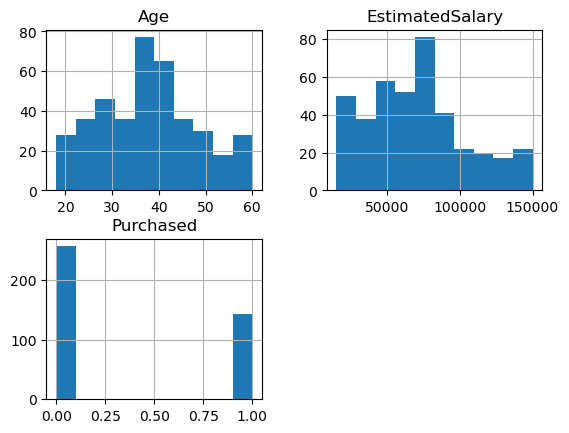

In [231]:
df.hist() # seems that our dataset is unbalanced again: more 0's than 1's. We will see the consequences via percision and recall


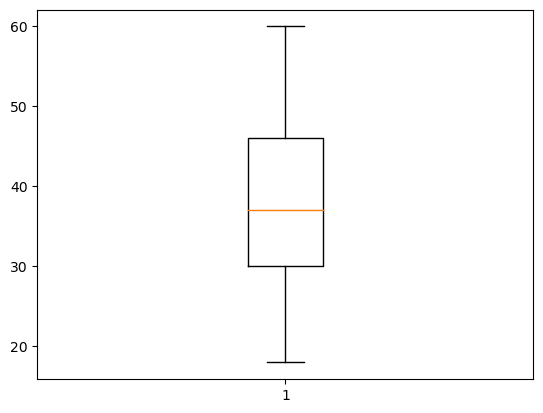

In [232]:

plt.boxplot(df["Age"])
plt.show()

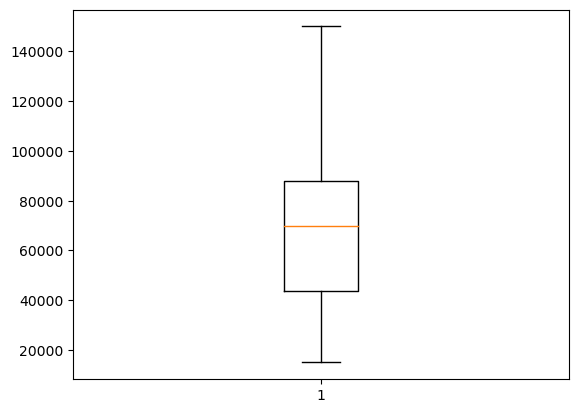

In [233]:
plt.boxplot(df["EstimatedSalary"])
plt.show()

In [234]:
# it does not seem that our data is very skewed, although we have a hint for some skewness for EstimatedSalary 

In [235]:
class OutlierRemover(BaseEstimator,TransformerMixin): # our own class to remove outliers - we will insert it to the pipeline
    
    def __init__(self,factor=1.5):
        self.factor = factor # higher the factor, extreme would be the outliers removed.
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr)) 
        self.upper_bound.append(q3 + (self.factor * iqr))
        self.median.append(X.median())

    def fit(self,X,y=None): # for each coulmn we will append corresponding boundary and the median value
        self.median = []
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None): # then, with transform we will check is a value goes beyond the boundary, if so we replace it
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy() # change the copy
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = self.median[i] # replace outliers with the median
            X.iloc[:, i] = x # make the column copy

        return X # our transformed df

In [236]:
factors = list(range(11)) # factors for our outlier class

# now, define a grid for params search for our SVC pipeline.

param_grid = {'outlier_removal__outlier_remover__factor':factors, \
              "SVC__kernel":['linear', 'poly', 'rbf', 'sigmoid'],
              "SVC__C":uniform(loc=1, scale=5), # reg param
             } 

In [237]:
# lets form our pipelines, each will include normalizer, outlier detection class instance and final estimator (model)



ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(),list(range(df.shape[1]-1))]])

# we have to specify which columns (with indices) will be transformed. We dont really want to remove outliers from [0,1] class (Purchased)

pipe1 = Pipeline(steps=[['outlier_removal',ct], ['scalar', StandardScaler()], ['hard_marg_svc',svm.LinearSVC() ]]) 
pipe2 = Pipeline(steps=[['outlier_removal',ct], ['scalar', StandardScaler()], ['soft_marg_svc',svm.SVC(kernel='linear')]]) 
pipe3 = Pipeline(steps=[['outlier_removal',ct], ['scalar', StandardScaler()], ['SGD',SGDClassifier(loss= "hinge")]]) 
pipe4 = Pipeline(steps=[['outlier_removal',ct], ['scalar', StandardScaler()], ['hard_marg_svc_rbf',svm.SVC(kernel='rbf',random_state=0)]])
pipe5 = Pipeline(steps=[['outlier_removal',ct], ['scalar', StandardScaler()], ['SVC',svm.SVC()]])

lst_of_pipes =  [pipe1,pipe2,pipe3,pipe4]

# our randomized search for the 5th pipeline
gs = RandomizedSearchCV(estimator= pipe5, param_distributions  = param_grid, scoring='accuracy', cv = 5,random_state=42)



In [238]:
def analyze_class_with_metrics(model,x,y,folds = 5): # display all mettrics for the pipelines
    d = x
    print(f"model: {model.steps[-1][0]}")
    scores = cross_val_score(model, d, y,scoring="accuracy", cv=folds).mean() # use cross valid since our dataset is not that big
    scores1 = cross_val_score(model, d, y,scoring="precision", cv=folds).mean()
    scores2 = cross_val_score(model, d, y,scoring="recall", cv=folds).mean()
    scores3 = cross_val_score(model, d, y,scoring="f1", cv=folds).mean()
    scores4 = cross_val_score(model, d, y,scoring="roc_auc", cv=folds).mean()
    print(f"mean accuracy: {scores}\n mean precision: {scores1}\n mean recall: {scores2}\n mean f1 score: {scores3}\n mean area under the ROC curve: {scores4}")
    return 

In [239]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:df.shape[1]-1], df["Purchased"], test_size=0.33, random_state=42)

In [240]:
# note that hard margin SVC does not allow any fines towards the margin and the width of the dividing strip between support vectors
# while with soft margin we set this "fine" (or epsilon), thus letting our classifer to make some mistakes, 
# like with soft SVC margin has to >= 1, but for soft SVC it can be >= 1 - epsilon (basically fine)

In [241]:
for pipe in lst_of_pipes:
    analyze_class_with_metrics(pipe, X_train, y_train)
    print()

model: hard_marg_svc
mean accuracy: 0.8170510132774285
 mean precision: 0.811888111888112
 mean recall: 0.6152046783625731
 mean f1 score: 0.6916594633872517
 mean area under the ROC curve: 0.9109992574027663

model: soft_marg_svc
mean accuracy: 0.820754716981132
 mean precision: 0.8316572316572317
 mean recall: 0.6046783625730994
 mean f1 score: 0.6946854529724386
 mean area under the ROC curve: 0.9079216559918315

model: SGD
mean accuracy: 0.8394828791055206
 mean precision: 0.7922574157868275
 mean recall: 0.85906432748538
 mean f1 score: 0.6543257103257102
 mean area under the ROC curve: 0.8586484730344379

model: hard_marg_svc_rbf
mean accuracy: 0.8842068483577916
 mean precision: 0.8259896800825594
 mean recall: 0.8573099415204677
 mean f1 score: 0.8356479723921584
 mean area under the ROC curve: 0.9350761162164671



In [242]:
# as we can see, SVC with rbf kernel gave the best performance:
# it has the best mean accuracy and area under the ROC curve is almost 100% (1) - 93%.
# Besides, we see that both percision and recall are satisfying in comparison with the others (as a result f1 score is also the best)
# meaning that our model is good in both recognizing 1's and 0's


# clearly, we have to add extra dimensions (add extra features) to build an optimal hyperplane (from SVC point of view, of course).
# SVC with linear kernel (where we did not add any extra features) gave us worse performance rather than SVC with rbf kernel.

# So, conclusion as from now: we have to add more features (with kernels) to improve the quality of model.


In [243]:
# As for the other models:

# hard margin  SVC gave us good accuracy, but if we look closer on recall thins are not so great!
# only 60% of 1's were correcly classified, meaning that there were a lot of false negatives!
# percision is good, because our model was able to properly distinguish 0's from 1's (but not vice versa), 
# hence amount of false positives will be low.
     
# in the other words, when model says "0" - most of the times it will be right, so the amount of false positives will be low,
# thus percision will be not that bad. But again, recall is not looking good!

# and this pattern (basically, consequence of the unbalanced dataset) is present for each model, except for the last one (with rbf kernel)
# generally good accuracy but low (relatively) recall, meaning that we are bad at learning how to distinguish 1 from 0
# but good vice versa


In [244]:
# we found out that we have to set something else but not "linear" for kernel in SVC to improve the quality of our model
# also, we can find optimal reg parametr (controling how wide dividing strip is going to be, lower the C value - wider the gap)
# finally, we can also try to find optimal factor for outliers detection


# rand grid search can help us to imporve our model (find optimal hypers from our grid)

In [245]:
gs.fit(X_train,y_train) # run our randomized search
d = gs.best_params_

In [246]:
d # optimal, at least from our grid

{'SVC__C': 3.229163764267956,
 'SVC__kernel': 'rbf',
 'outlier_removal__outlier_remover__factor': 10}

In [247]:
reg = d["SVC__C"]
ker = d["SVC__kernel"]
factor = d["outlier_removal__outlier_remover__factor"]

In [248]:
# redifine our column trans with new factor (instead of default 1.5) and redifine our 5th pipe with the new params

ct1 = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(factor),list(range(df.shape[1]-1))]])
pipe5 = Pipeline(steps=[['outlier_removal',ct1], ['scalar', StandardScaler()], ['SVC',svm.SVC(kernel = ker, C=reg)]])

In [249]:
pipe5.fit(X_train, y_train) # train the pipe

Pipeline(steps=[('outlier_removal',
                 ColumnTransformer(transformers=[['outlier_remover',
                                                  OutlierRemover(factor=10),
                                                  [0, 1]]])),
                ('scalar', StandardScaler()),
                ['SVC', SVC(C=3.229163764267956)]])

In [250]:
analyze_class_with_metrics(pipe5, X_train, y_train)

model: SVC
mean accuracy: 0.8916142557651991
 mean precision: 0.8295611086539878
 mean recall: 0.8789473684210527
 mean f1 score: 0.848675533066778
 mean area under the ROC curve: 0.9463552399517312


In [251]:
# this is even better than SVC just with rbf!
# better accuracy and area uder the curve
# also, recall's got even higher: 87%.

# In my opinion, this model is the best among the others

In [252]:
hats = pipe5.predict(X_test) # lets see how model performs on the test set

In [253]:
def see_t(actual, preds):
    scores = accuracy_score(y_test,hats)
    scores1 = precision_score(y_test,hats)
    scores2 =  recall_score(y_test,hats)
    scores3 =  f1_score(y_test,hats)
    scores4 =  roc_auc_score(y_test,hats)
    print(f"accuracy: {scores}\nprecision: {scores1}\nrecall: {scores2}\nf1 score: {scores3}\narea under the ROC curve: {scores4}")
    return 

In [254]:
see_t(y_test, hats)

accuracy: 0.9545454545454546
precision: 0.9107142857142857
recall: 0.9807692307692307
f1 score: 0.9444444444444444
area under the ROC curve: 0.9591346153846154


In [255]:
# we got very good measurments, all of them are above 85%!
# lets compare it to the SVC just with rbf kernel

In [256]:
pipe4.fit(X_train, y_train)
hats = pipe4.predict(X_test)
see_t(y_test, hats)

accuracy: 0.946969696969697
precision: 0.9090909090909091
recall: 0.9615384615384616
f1 score: 0.9345794392523366
area under the ROC curve: 0.9495192307692308


In [257]:
# and we see that the pipe (model), with optimal hyper params performed better.

In [258]:
#finally, lets add predicions column to the datset

In [259]:
hats = pipe5.predict(df[["Age", "EstimatedSalary"]])

In [260]:
df["Preds"] = hats

In [261]:
df.head(n=50)

,Age,EstimatedSalary,Purchased,Preds
0,19.000000,19000.000000,0,0
1,35.000000,20000.000000,0,0
2,26.000000,43000.000000,0,0
3,27.000000,57000.000000,0,0
4,19.000000,76000.000000,0,0
5,27.000000,60594.488189,0,0
6,27.000000,84000.000000,0,0
7,32.000000,150000.000000,1,1
8,25.000000,33000.000000,0,0
9,35.000000,65000.000000,0,0


In [262]:
# thank you!